Implementation of Physics-informed discovery of marine vessels dynamics from noisy data

Author: Agus Hasan, Department of ICT and Natural Sciences, Norwegian University of Science and Technology, Norway

[1] A. Hasan, “Physics-informed discovery of marine vessels dynamics from noisy data,” Ocean Engineering, vol. 317, p. 120032, Feb. 2025, doi: 10.1016/j.oceaneng.2024.120032.

In [12]:
import yaml
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import cyipopt as ipopt

In [13]:
# Validating IPOPT
from scipy.optimize import rosen, rosen_der
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = ipopt.minimize_ipopt(rosen, x0, jac=rosen_der)
print(res)

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 2.1081754165231008e-18
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
     nit: 37
    info:     status: 0
                   x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00
                        1.000e+00]
                   g: []
             obj_val: 2.1081754165231008e-18
              mult_g: []
            mult_x_L: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00]
            mult_x_U: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 200
    njev: 39


In [14]:
class VesselModel:
    def __init__(self, params_url="params_real.yaml"):
        params_yaml = open(params_url, 'r')
        self.params = yaml.safe_load(params_yaml)
        params_yaml.close()

        keys = ['m', 'x_g', 'I_z', 'X_du', 'Y_dv', 'Y_dr', 'N_dv', 'N_dr']
        self.m, self.x_g, self.I_z, self.X_du, self.Y_dv, self.Y_dr, self.N_dv, self.N_dr = self.retrieve_params(keys)

        keys = ['X_u', 'X_uu', 'Y_v', 'Y_vv', 'Y_r', 'N_v', 'N_r', 'N_rr']
        self.X_u, self.X_uu, self.Y_v, self.Y_vv, self.Y_r, self.N_v, self.N_r, self.N_rr = self.retrieve_params(keys)

        self.M = np.zeros((3,3))
        self.M[0,0] = self.m - self.X_du
        self.M[1,1] = self.m - self.Y_dv
        self.M[1,2] = self.m*self.x_g - self.Y_dr
        self.M[2,1] = self.m*self.x_g - self.N_dv
        self.M[2,2] = self.I_z - self.N_dr
        #print(M)

        self.Minv = inv(self.M)


    def rk4(self, Sn, Un, dt):
        k1 = self.dynamics(Sn, Un)
        k2 = self.dynamics(Sn + dt*k1/2, Un)
        k3 = self.dynamics(Sn + dt*k2/2, Un)
        k4 = self.dynamics(Sn + dt*k3, Un)
        Snp1 = Sn + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        return Snp1
    
    def euler(self, Sn, Un, dt):
        Snp1 = Sn + dt*self.dynamics(Sn, Un)
        return Snp1
    
    def hermite_simpson(self, S1, S2, Un, dt):
        ds1 = self.dynamics(S1, Un)
        ds2 = self.dynamics(S2, Un)

        midpoint = 0.5 * (S1 + S2) + dt/8.0 * (ds1 - ds2)
        dmid = self.dynamics(midpoint, Un)

        f = S1 + dt/6.0 * (ds1 + 4.0 * dmid + ds2) - S2
        return f
    
    def retrieve_params(self, keys):
        values = [self.params[key] for key in keys]
        return values
    
    def dynamics(self, Sn: np.ndarray, Un: np.ndarray):
        # state s in form [x y psi u v r]
        x, y, psi, u, v, r = Sn

        # Calculate change in NED position
        R = np.eye(3)
        R[0,0] = np.cos(psi)
        R[0,1] = -np.sin(psi)
        R[1,0] = np.sin(psi)
        R[1,1] = np.cos(psi)
        #print(R)

        uvr = np.array([u,v,r])
        dxypsi = R @ uvr

        # Calculate change in  body velocity
        C = np.zeros((3,3))
        C[0,2] = -(self.m-self.Y_dv)*v - (self.m*self.x_g-self.Y_dr)*r
        C[1,2] = (self.m-self.X_du)*u
        C[2,0] = (self.m-self.Y_dv)*v + (self.m*self.x_g-self.Y_dr)*r
        C[2,1] = -(self.m-self.X_du)*u
        #print(C)

        D = np.zeros((3,3))
        D[0,0] = -self.X_u - self.X_uu*np.abs(u)
        D[1,1] = -self.Y_v - self.Y_vv*np.abs(v)
        D[1,2] = -self.Y_r
        D[2,1] = -self.N_v
        D[2,2] = -self.N_r - self.N_rr*np.abs(r)
        #print(D)

        duvr = self.Minv@Un - self.Minv@(C+D)@uvr

        dsdt = np.zeros(6)
        dsdt[:3] = dxypsi
        dsdt[3:] = duvr
        return dsdt

In [15]:
class TrajOpt:
    def __init__(self, model: VesselModel, N, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf):
        self.model = model
        self.N = N
        self.ns = ns
        self.nu = nu
        self.dt = dt

        self.Qvec = Qvec
        self.Rvec = Rvec
        self.Qfvec = Qfvec
        self.Q = np.diag(Qvec)
        self.R = np.diag(Rvec)
        self.Qf = np.diag(Qfvec)

        self.s0 = s0
        self.sf = sf

        # Control clamps
        self.u_min = -10
        self.u_max = 10

        self.Z0 = self.make_initial_guess()
        assert len(self.Z0) == N*ns + (N-1)*nu, "Length of initial guess does not match length calculated from given N, nx, and nu"

    def make_initial_guess(self):
        states = np.zeros((self.N,self.ns))
        states[0] = self.s0

        inputs = np.zeros((self.N-1, self.nu))

        states_flat = states.flatten()
        inputs_flat = inputs.flatten()
        guess = np.concatenate((states_flat, inputs_flat))
        return guess
    
    def flat2vec(self, Z):
        states_flat = Z[:self.N*self.ns]
        inputs_flat = Z[self.N*self.ns:]
        states = states_flat.reshape((self.N, self.ns))
        inputs = inputs_flat.reshape((self.N-1, self.nu))
        return states, inputs
    
    def LQRcost(self, Z):
        states, inputs = self.flat2vec(Z)
        
        cost = 0
        for i in range(self.N-1):
            sn = states[i]
            un = inputs[i]
            # LQR Cost
            cost += 0.5 * (sn-self.sf) @ self.Q @ (sn-self.sf)
            cost += 0.5 * un @ self.R @ un
        
        cost += (states[-1]-self.sf) @ self.Qf @ (states[-1]-self.sf) # LQR terminal cost
        
        return cost
    
    def LQRcost_fast(self, Z):
        states, inputs = self.flat2vec(Z)
        S = states[:-1]

        cost = 0
        cost += np.sum(0.5 * np.vecdot((S-self.sf), np.multiply(self.Qvec, S-self.sf)))
        cost += np.sum(0.5 * np.vecdot((states[-1]-self.sf), np.multiply(self.Qfvec, states[-1]-self.sf)))
        #print(f"cost from states: {cost}")
        cost += np.sum(0.5 * np.vecdot(inputs, np.multiply(self.Rvec, inputs)))
        #print(f"cost with inputs: {cost}")

        return cost
    
    def equality_constraints(self, Z):
        states, inputs = self.flat2vec(Z)

        constraints = []

        # Initial and terminal constraints
        initial_constraint = states[0] - self.s0
        terminal_constraint = states[-1] - self.sf
        constraints.extend(initial_constraint)
        constraints.extend(terminal_constraint)

        # Dynamics constraints
        for i in range(self.N-1):
            sn = states[i]
            snp1 = states[i+1]
            un = inputs[i]
            #dyn_snp1 = self.model.euler(sn, un, self.dt)
            #dynamics_constraint = snp1 - dyn_snp1
            dynamics_constraint = self.model.hermite_simpson(sn, snp1, un, self.dt)
            constraints.extend(dynamics_constraint)

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return np.array(constraints)
    
    def equality_constraints_fast(self, Z):
        states, inputs = self.flat2vec(Z)

        constraints = np.zeros((self.N-1+2, self.ns))

        # Initial and terminal constraints
        initial_constraint = states[0] - self.s0
        terminal_constraint = states[-1] - self.sf
        constraints[-1] = initial_constraint
        constraints[-2] = terminal_constraint

        # Dynamics constraints
        for i in range(self.N-1):
            sn = states[i]
            snp1 = states[i+1]
            un = inputs[i]
            #dyn_snp1 = self.model.euler(sn, un, self.dt)
            #dynamics_constraint = snp1 - dyn_snp1
            dynamics_constraint = self.model.hermite_simpson(sn, snp1, un, self.dt)
            constraints[i] = dynamics_constraint

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return constraints.flatten()
    
    def inequality_constraints(self, Z):
        states, inputs = self.flat2vec(Z)

        constraints = []

        # Control clamping
        for i in range(self.N-1):
            un = inputs[i]
            constraints.extend(un-self.u_min)
            constraints.extend(self.u_max-un)

        # Simulated obstacles
        for i in range(self.N):
            sn = states[i]
            X = sn[0]
            Y = sn[1]
            oc1 = (X-0.25)**2 + (Y-0.25)**2 - 0.1**2
            oc2 = (X-0.6)**2 + (Y-0.4)**2 - 0.1**2
            oc3 = (X-0.75)**2 + (Y-0.75)**2 - 0.1**2
            constraints.extend([oc1, oc2, oc3])

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return np.array(constraints)
    
    def inequality_constraints_fast(self, Z):
        states, inputs = self.flat2vec(Z)

        constraints_min_controls = inputs - self.u_min
        constraints_max_controls = -inputs + self.u_max
        X = states[:,0]
        Y = states[:,1]
        oc1 = (X-0.25)**2 + (Y-0.25)**2 - 0.1**2
        oc2 = (X-0.8)**2 + (Y-0.3)**2 - 0.25**2
        oc3 = (X-0.75)**2 + (Y-0.75)**2 - 0.1**2
        oc4 = (X-0.3)**2 + (Y-0.8)**2 - 0.25**2
        constraints = np.concatenate((constraints_min_controls.flatten(), constraints_max_controls.flatten(), oc1.flatten(), oc2.flatten(), oc3.flatten(), oc4.flatten()))

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return np.array(constraints)
    
    def exec_trajopt(self):
        constraints = [
            {"type": "eq", "fun": self.equality_constraints_fast},
            {"type": "ineq", "fun": self.inequality_constraints_fast}
        ]

        self.sol = ipopt.minimize_ipopt(
            fun=self.LQRcost_fast,
            x0=self.Z0,
            constraints=constraints,
            tol=1e-3,
            options={"print_level": 5}
        )

In [16]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3

# Cost matrices
Qvec = np.ones(ns)
Rvec = np.ones(nu)
Qfvec = np.ones(ns)

# Problem Definition
s0 = np.zeros(6)
sf = np.zeros(6)
sf[0] = 1
sf[1] = 1

In [17]:
model = VesselModel()
trajoptimizer = TrajOpt(model, N, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf)
trajoptimizer.exec_trajopt()

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   543582
Number of nonzeros in inequality constraint Jacobian.:   891618
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      897
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      994
        inequality constraints with only lower bounds:      994
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+02 1.00e+00 3.03e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 431.96724598066487
       x: [ 0.000e+00  0.000e+00 ... -3.737e+00  1.559e+00]
     nit: 65
    info:     status: 0
                   x: [ 0.000e+00  0.000e+00 ... -3.737e+00  1.559e+00]
                   g: [-3.605e-14 -5.063e-14 ...  4.677e-01  4.675e-01]
             obj_val: 431.96724598066487
              mult_g: [-4.041e+02  1.564e+02 ...  2.246e-08 -2.202e-10]
            mult_x_L: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 74
    njev: 35
4.534081287955422


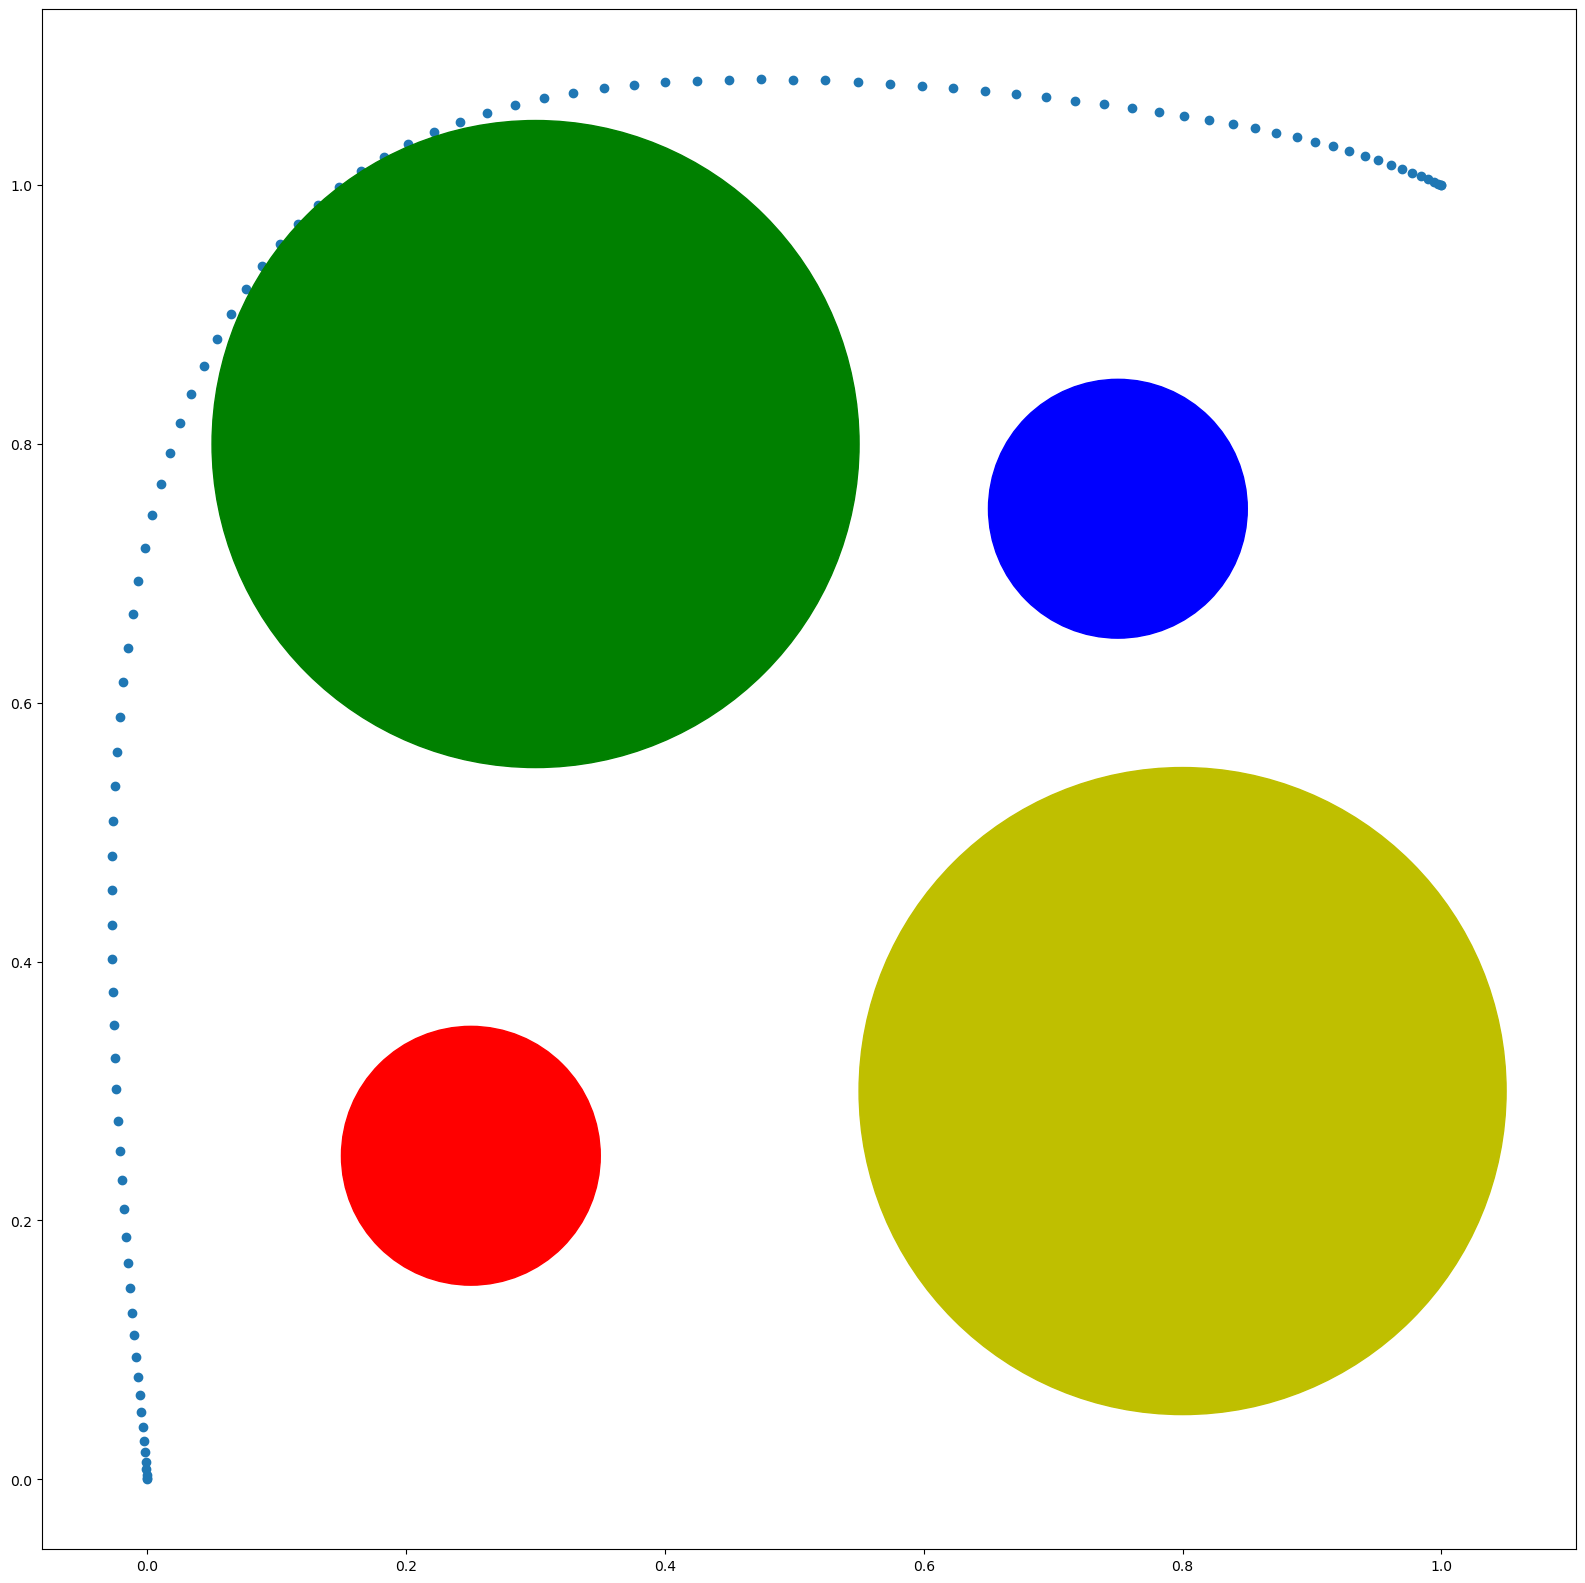

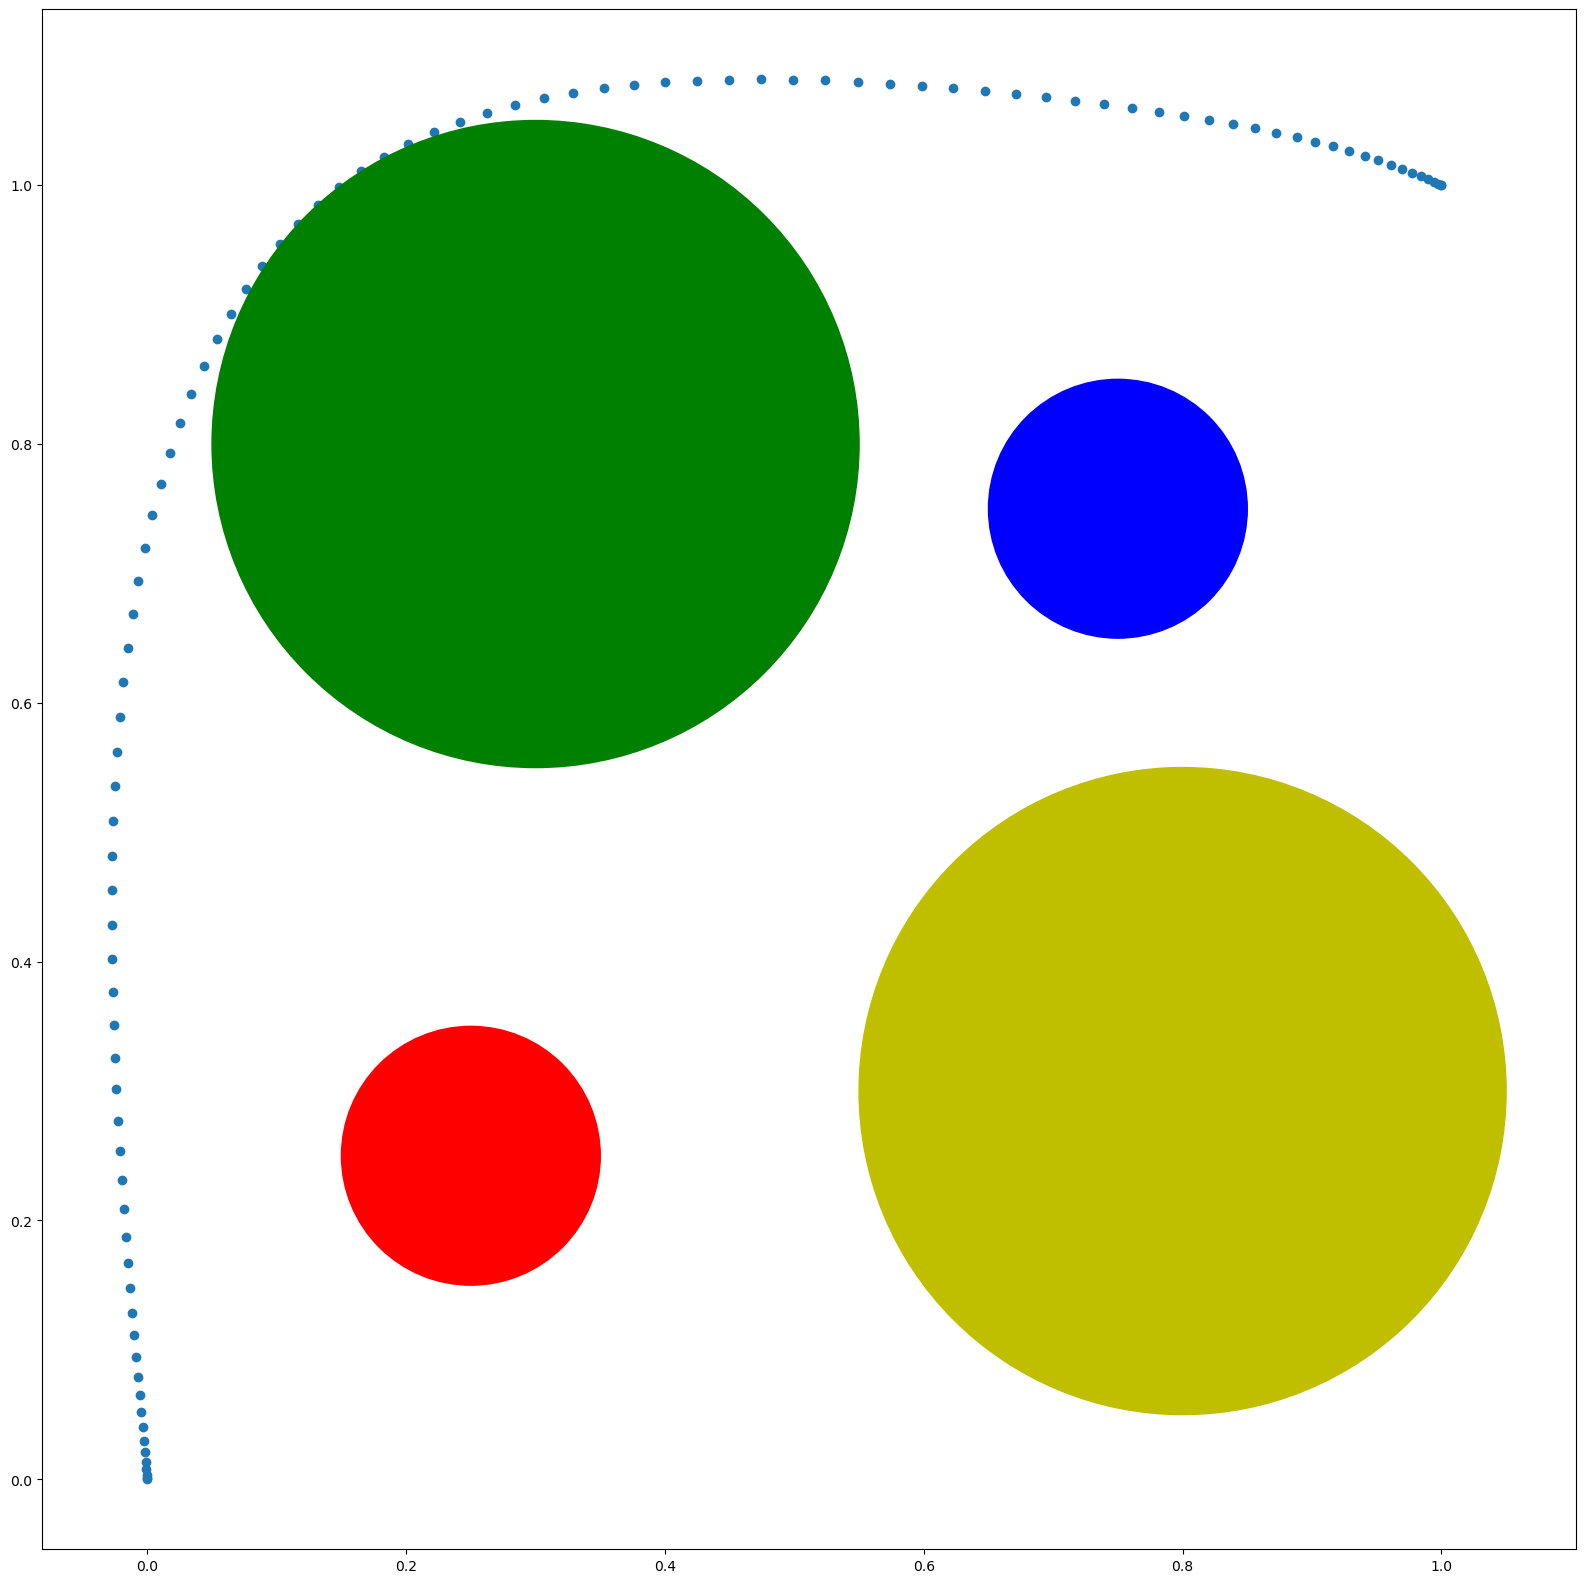

In [18]:
print(trajoptimizer.sol)
S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
print(np.max(U))
ps = list(zip(*S))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.scatter(ps[1], ps[0])
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.set_aspect('equal', adjustable='box')
plt.show()

Sfwd = np.zeros((N,ns))
Sfwd[0] = S[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

ps = list(zip(*Sfwd))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.scatter(ps[1], ps[0])
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.set_aspect('equal', adjustable='box')
plt.show()

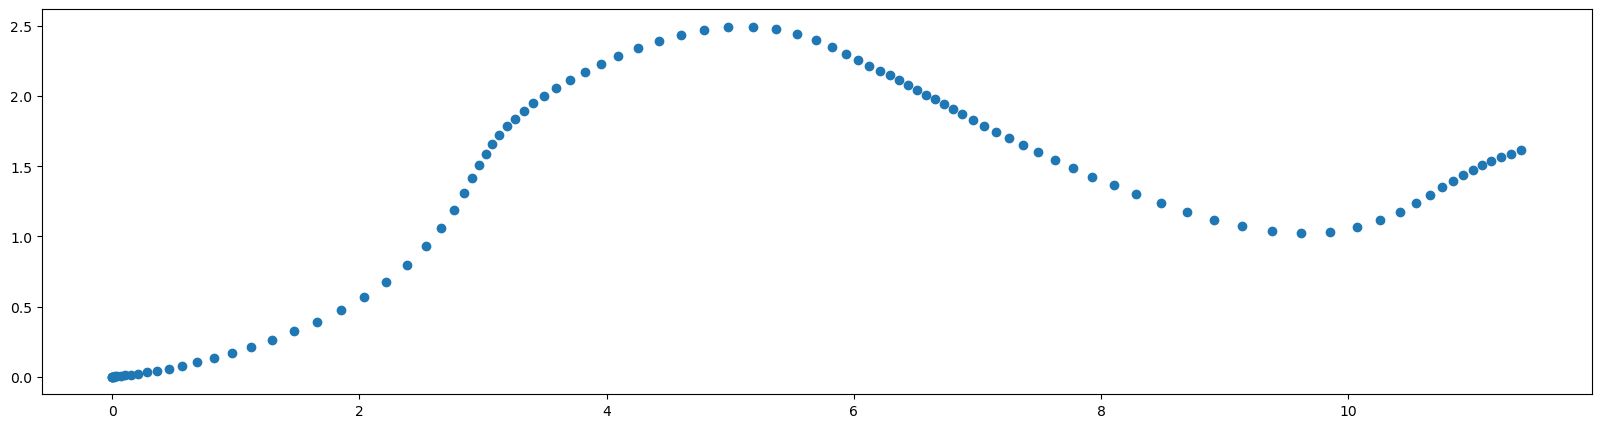

In [19]:
Sn = np.zeros(6)
Un = np.zeros(3)
Un[0] = 5
Un[1] = 5

S = np.zeros((N, ns))
S[0] = Sn

U = np.zeros((N-1, nu))
for i in range(N-1):
    U[i] = [40*np.sin(dt*i),np.cos(dt*i),np.cos(dt*i)]

for i in range(N-1):
    S[i+1] = model.rk4(S[i], U[i], dt)

ps = list(zip(*S))
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
axes.scatter(ps[0], ps[1])
plt.show()